In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append("../utils/")
from utils import features

In [3]:
pd.options.display.float_format = '{:.6f}'.format

In [4]:
infile = "../data/leaderboard-pages.csv"

In [5]:
%%time 
NROWS = 1000000
df = pd.read_csv(infile, nrows=NROWS)
print "{} rows".format(df.shape[0])
print "{} columns".format(df.shape[1])

772276 rows
34 columns
CPU times: user 4.76 s, sys: 477 ms, total: 5.23 s
Wall time: 5.25 s


In [6]:
%%time 
df = features.get_features_dataframe(df, verbose=True)
print "{} rows".format(df.shape[0])
print "{} columns".format(df.shape[1])
df.head(1).T

Casting columns to data types
Adding overall sums for each metric
Dropped 101654 rows with low playtime
670622 rows
54 columns
CPU times: user 1min 57s, sys: 5.92 s, total: 2min 2s
Wall time: 2min 1s


In [7]:
feature_cols = df.columns[df.columns.str.contains('normalized')].tolist()
feature_cols

['stats.normalized.accuracy',
 'stats.normalized.aggression',
 'stats.normalized.deaths.perhour',
 'stats.normalized.defensive_actions.perhour',
 'stats.normalized.kd',
 'stats.normalized.kills.perhour',
 'stats.normalized.losses.perhour',
 'stats.normalized.mobility',
 'stats.normalized.points.perbullet_fired',
 'stats.normalized.points.perhour',
 'stats.normalized.wins.perhour',
 'stats.normalized.wlr']

In [8]:
df_gameplay = df.ix[:,feature_cols]
df_gameplay.head(1).T

,0
stats.normalized.accuracy,0.174338
stats.normalized.aggression,0.624953
stats.normalized.deaths.perhour,11.001264
stats.normalized.defensive_actions.perhour,27.683651
stats.normalized.kd,0.848044
stats.normalized.kills.perhour,9.329550
stats.normalized.losses.perhour,1.885986
stats.normalized.mobility,0.912585
stats.normalized.points.perbullet_fired,0.024237
stats.normalized.points.perhour,12.705794


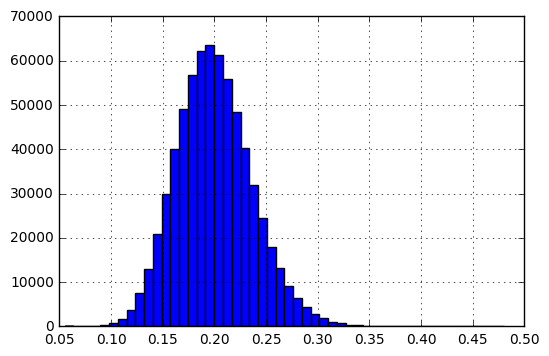

In [9]:
df_gameplay['stats.normalized.accuracy'].hist(bins=50)
plt.show()

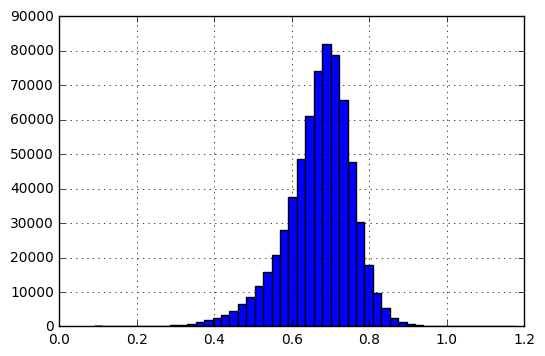

In [10]:
df_gameplay['stats.normalized.aggression'].hist(bins=50)
plt.show()

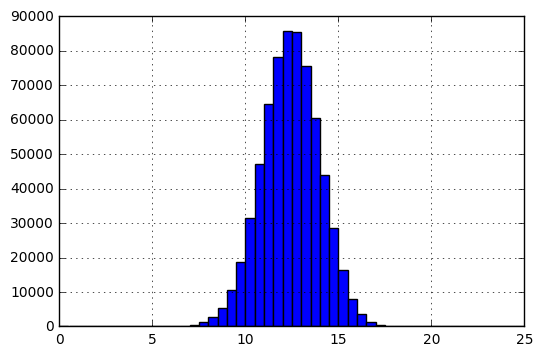

In [11]:
df_gameplay['stats.normalized.deaths.perhour'].hist(bins=50, range=(0,25))
plt.show()

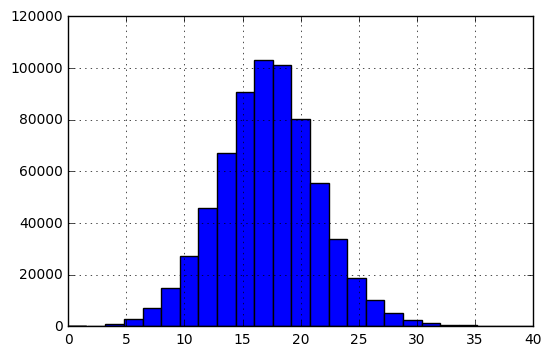

In [12]:
df_gameplay['stats.normalized.defensive_actions.perhour'].hist(bins=25, range=(0,40))
plt.show()

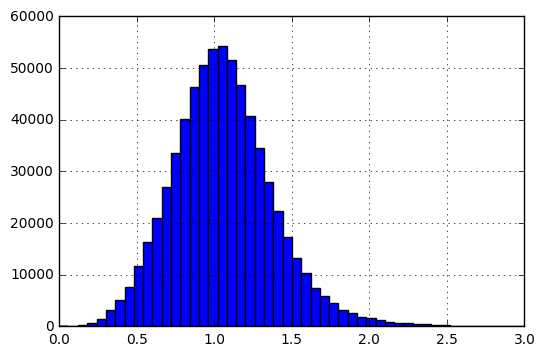

In [13]:
df_gameplay['stats.normalized.kd'].hist(bins=50, range=(0,3))
plt.show()

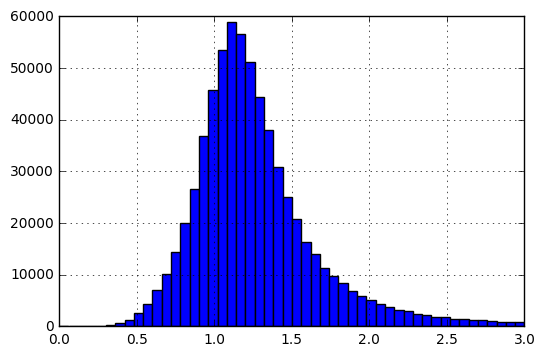

In [14]:
df_gameplay['stats.normalized.wlr'].hist(bins=50, range=(0,3))
plt.show()

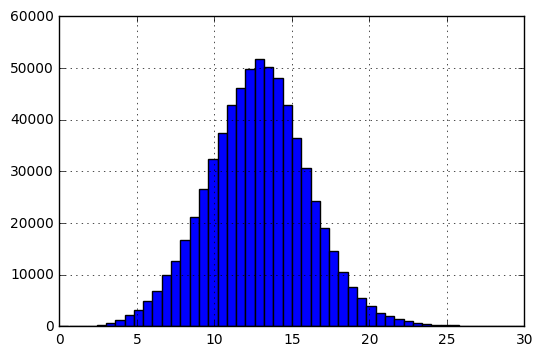

In [15]:
df_gameplay['stats.normalized.kills.perhour'].hist(bins=50, range=(0,30))
plt.show()

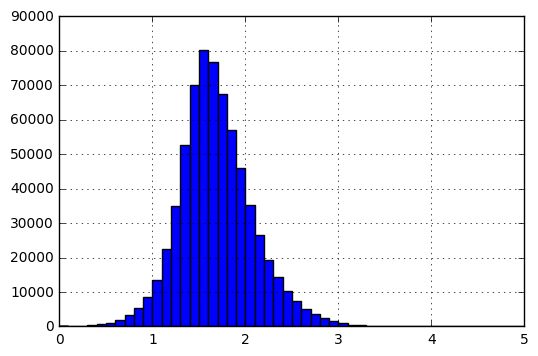

In [16]:
df_gameplay['stats.normalized.losses.perhour'].hist(bins=50, range=(0,5))
plt.show()

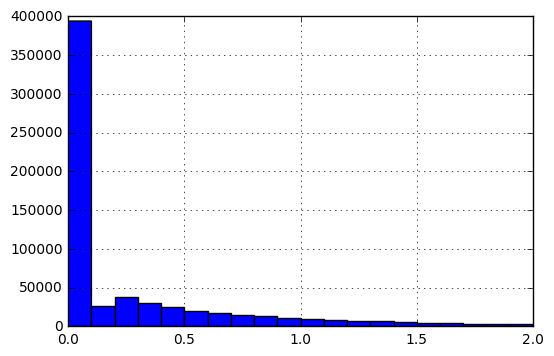

In [17]:
df_gameplay['stats.normalized.mobility'].hist(bins=20, range=(0,2))
plt.show()

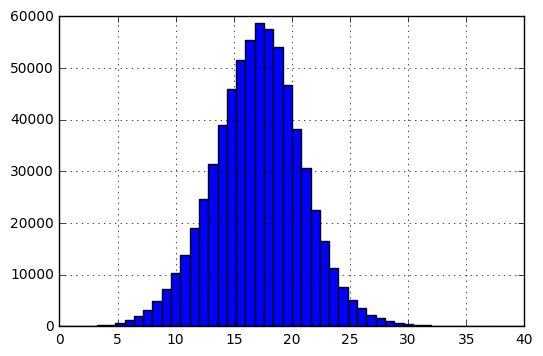

In [18]:
df_gameplay['stats.normalized.points.perhour'].hist(bins=50, range=(0,40))
plt.show()

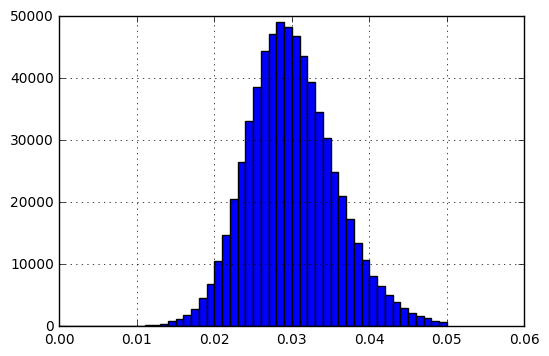

In [19]:
df['stats.normalized.points.perbullet_fired'].hist(bins=50, range=(0,0.05))
plt.show()

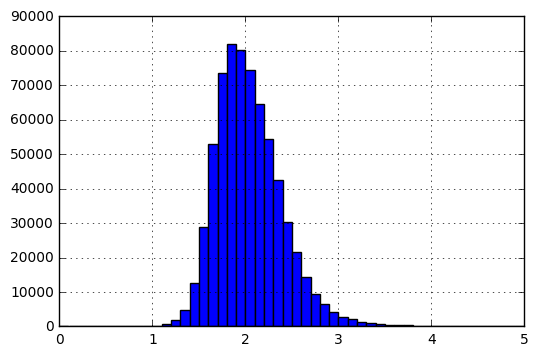

In [20]:
df_gameplay['stats.normalized.wins.perhour'].hist(bins=50, range=(0,5))
plt.show()

In [21]:
from sklearn.decomposition import pca
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [22]:
%%time 
scaler = MinMaxScaler(feature_range=(-1,1), copy=True).fit(df_gameplay)
# scaler = StandardScaler(copy=True).fit(df_gameplay)

X_scaled = pd.DataFrame(scaler.transform(df_gameplay), index=df_gameplay.index, columns=df_gameplay.columns)

reducer = pca.PCA(n_components=2, whiten=True).fit(X_scaled)
X_pca = pd.DataFrame(reducer.transform(X_scaled), index=X_scaled.index, columns=['pca1', 'pca2'])
X_pca.head()

CPU times: user 2.74 s, sys: 969 ms, total: 3.7 s
Wall time: 2.05 s


In [23]:
X = X_pca.copy().sample(n=10000).values
X

array([[ 1.37784163, -1.05459928],
       [-0.4329324 , -1.04459588],
       [-1.22690193, -1.45490189],
       ..., 
       [-0.86335355,  0.00369455],
       [ 1.21492596, -1.03919027],
       [-2.38262907, -0.64433099]])

In [24]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

('For n_clusters =', 4, 'The average silhouette_score is :', 0.31022022287656054)


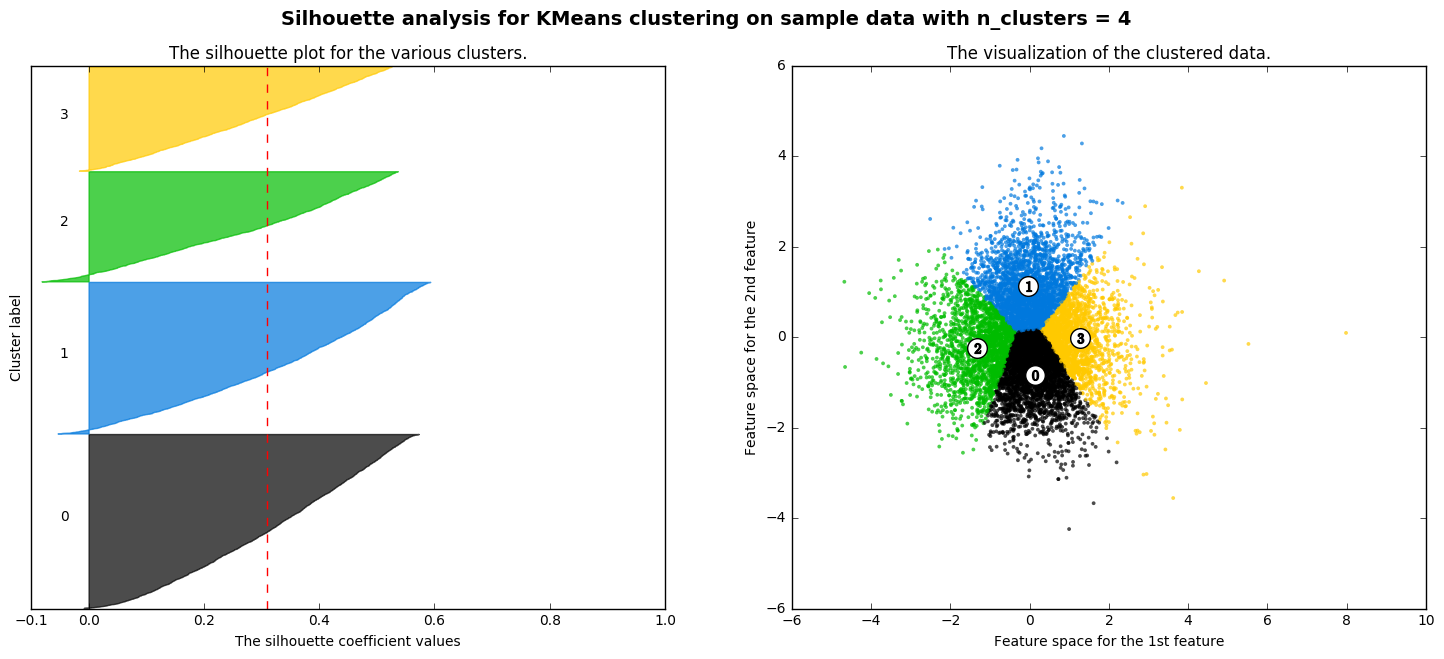

('For n_clusters =', 5, 'The average silhouette_score is :', 0.29996423403091538)


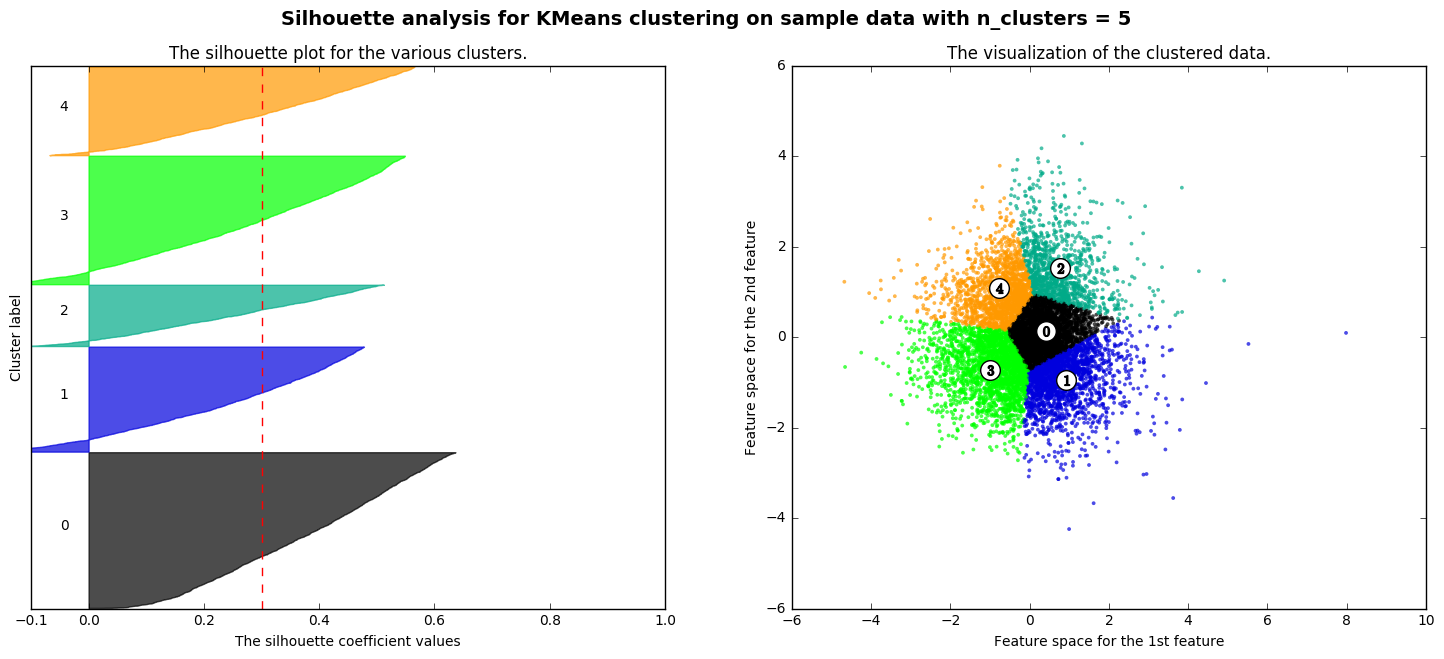

('For n_clusters =', 6, 'The average silhouette_score is :', 0.31995140832039226)


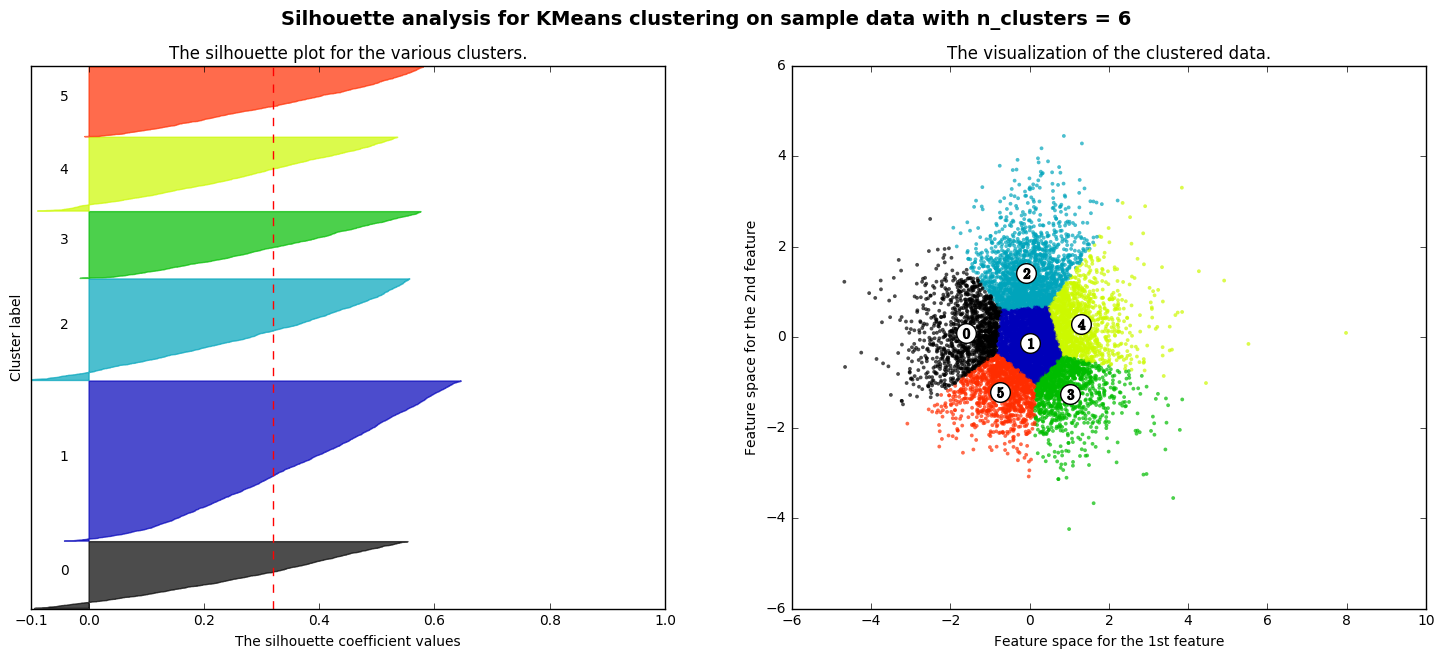

('For n_clusters =', 7, 'The average silhouette_score is :', 0.28217095612588994)


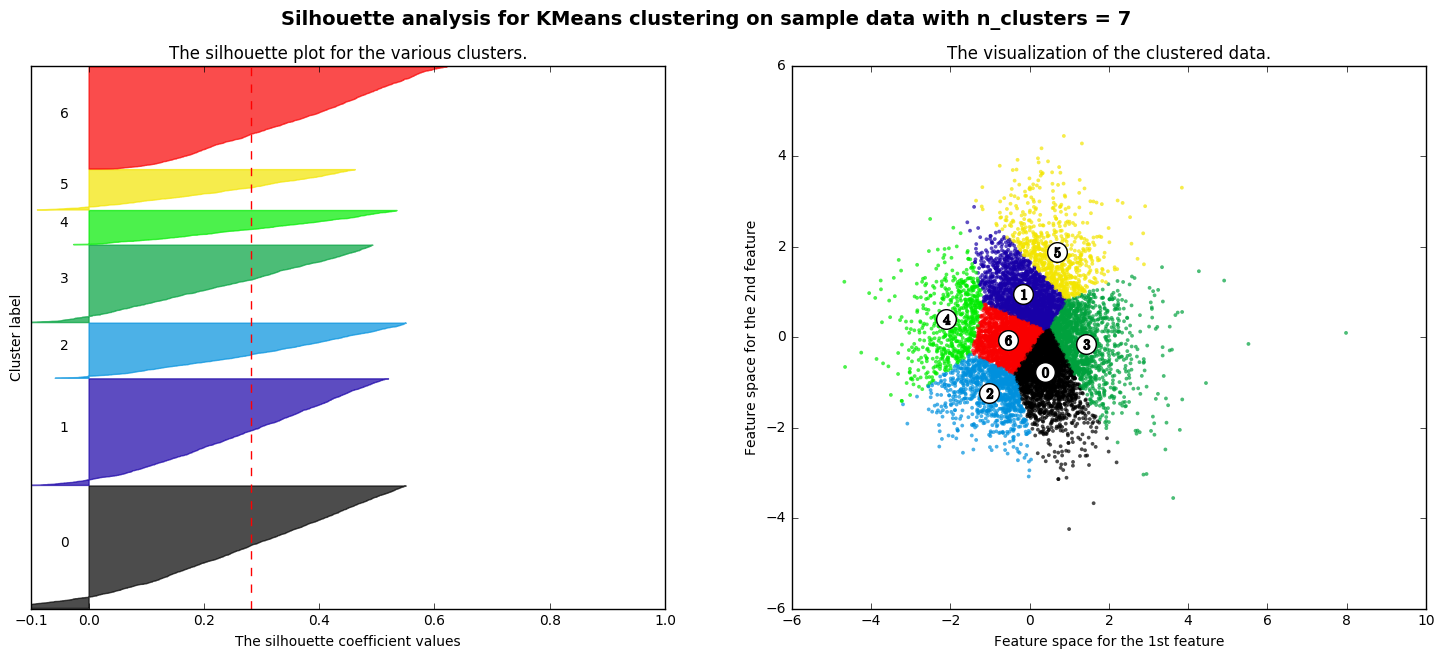

('For n_clusters =', 8, 'The average silhouette_score is :', 0.29028108762650789)


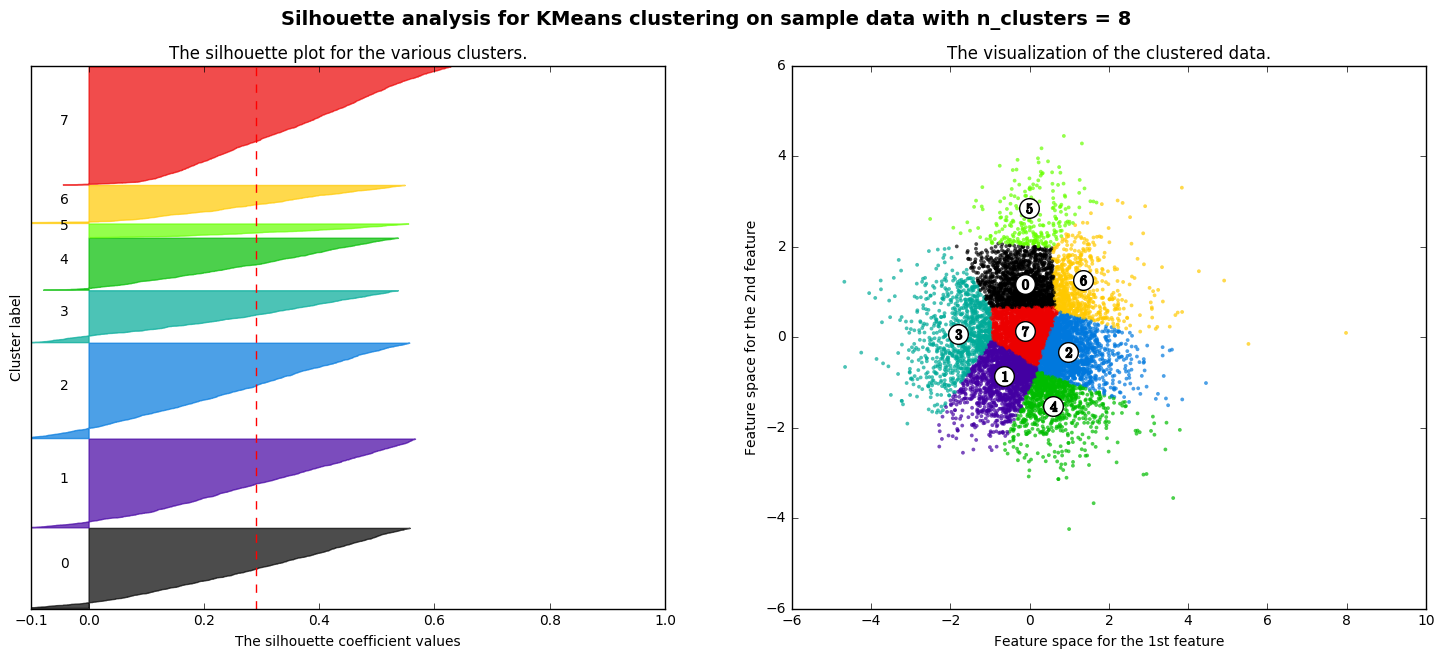

('For n_clusters =', 9, 'The average silhouette_score is :', 0.30732928895197731)


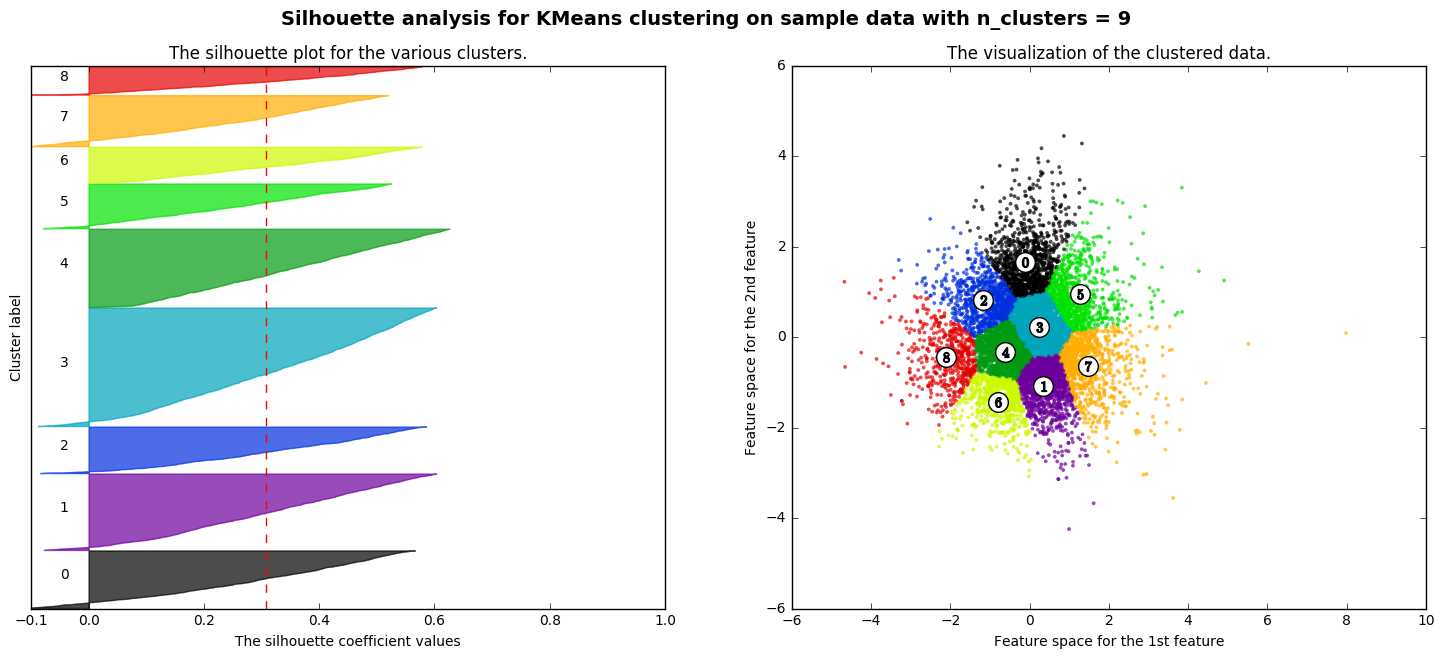

('For n_clusters =', 10, 'The average silhouette_score is :', 0.30094751252278995)


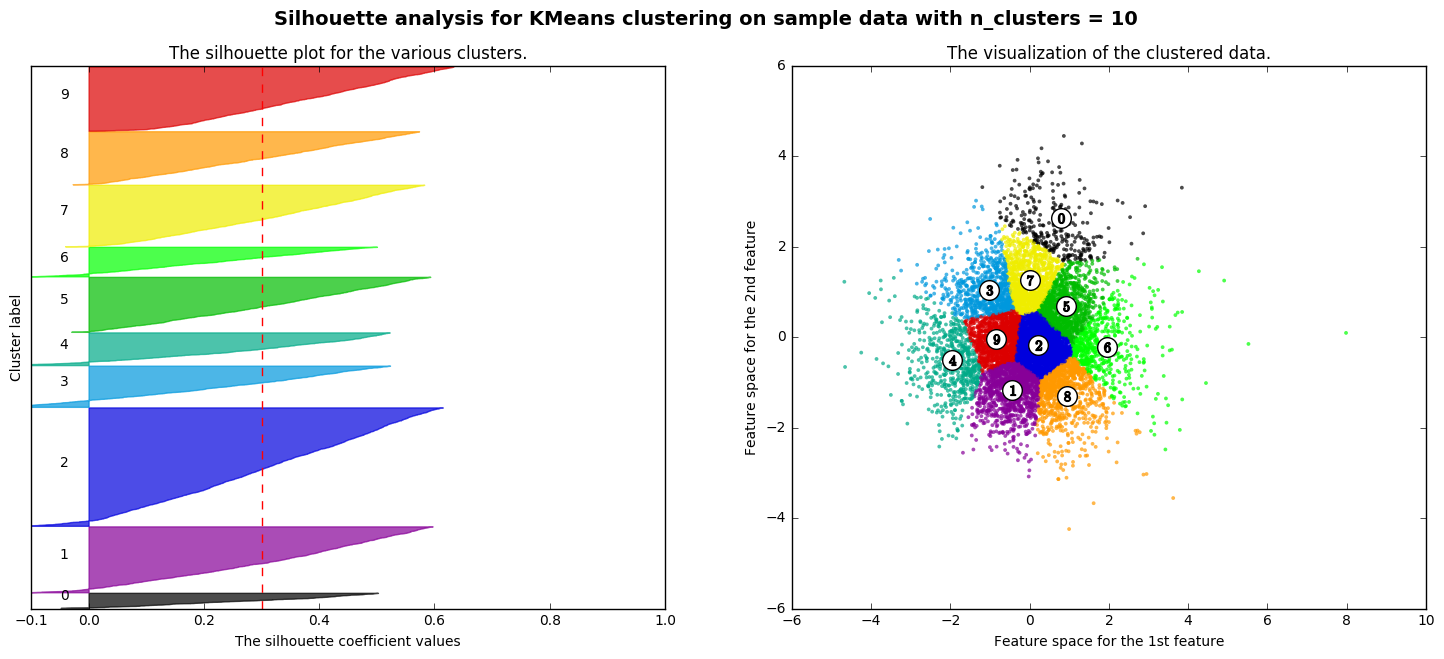

CPU times: user 53.2 s, sys: 13.4 s, total: 1min 6s
Wall time: 1min 1s


In [25]:
%%time 
range_n_clusters = range(4, 11)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=45,
                      n_init=10, max_no_improvement=10, verbose=0)

    # clusterer = KMeans(n_clusters=n_clusters, random_state=10, max_iter=3)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [26]:
print X[:, 0].mean()
print X[:, 1].mean()

-0.000967634551176
0.00547132909491


In [27]:
reducer.explained_variance_ratio_

array([ 0.46243376,  0.17548884])

In [28]:
print df.shape
print X_pca.shape

(670622, 54)
(670622, 2)


In [29]:
%%time 
clusterer = MiniBatchKMeans(init='k-means++', n_clusters=6, batch_size=45,
                  n_init=10, max_no_improvement=10, verbose=0)

# clusterer = KMeans(n_clusters=n_clusters, random_state=10, max_iter=3)
cluster_labels = clusterer.fit_predict(X_pca)

CPU times: user 3.56 s, sys: 35.1 ms, total: 3.6 s
Wall time: 3.6 s


In [30]:
df['label'] = cluster_labels.astype(int)

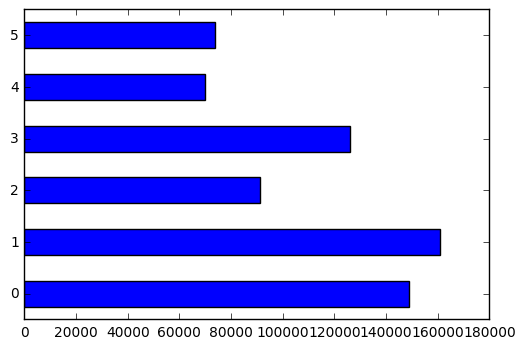

CPU times: user 241 ms, sys: 4.61 ms, total: 245 ms
Wall time: 244 ms


In [31]:
%%time 
pd.value_counts(df['label'], sort=False).plot(kind='barh')
plt.show()